In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
drive_dir = '/content/drive/MyDrive'

Mounted at /content/drive


## Loading of Stringer spontaneous data

includes some visualizations

In [ ]:
# @title Install dependencies
!pip install umap-learn --quiet
!pip install ipympl --quiet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA

import os
import torch
from torch import nn
from torch import optim
from pathlib import PureWindowsPath
import matplotlib as mpl

In [ ]:
'''
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True
'''

"\n# @title Figure settings\nfrom matplotlib import rcParams\n\nrcParams['figure.figsize'] = [20, 4]\nrcParams['font.size'] =15\nrcParams['axes.spines.top'] = False\nrcParams['axes.spines.right'] = False\nrcParams['figure.autolayout'] = True\n"

In [ ]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])



dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain.
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details.
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other.
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

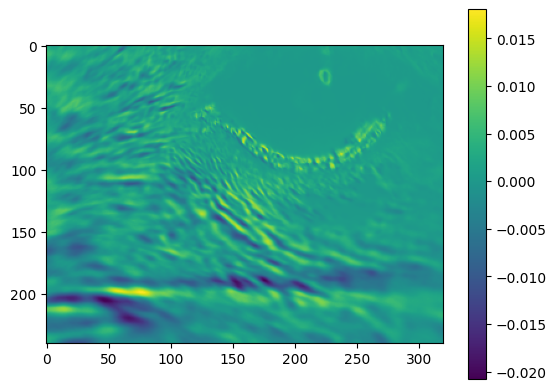

In [ ]:
T=11

face_movie = dat['beh_svd_mask'][...,T]
plt.figure()
plt.imshow(face_movie)
plt.colorbar()

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

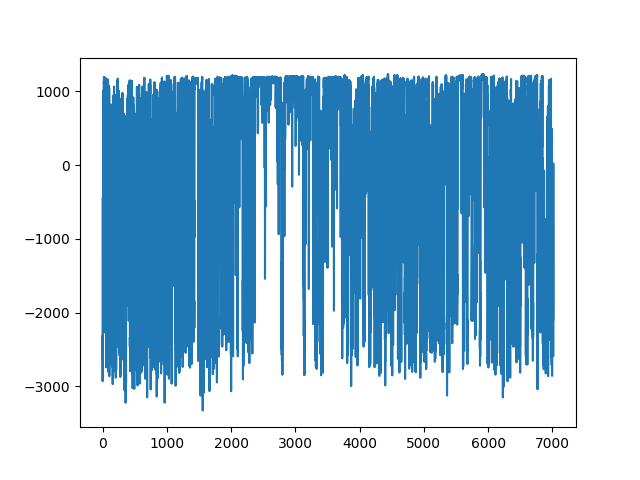

In [ ]:
%matplotlib widget
plt.figure()
plt.plot(dat['beh_svd_time'][:,0])

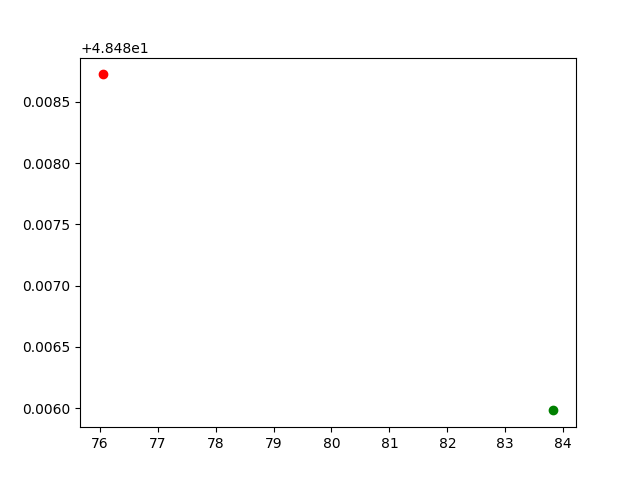

In [ ]:
plt.figure()
plt.scatter(dat['pupilCOM'][0,0], dat['pupilCOM'][0,1], c='r')
plt.scatter(dat['pupilCOM'][1,0], dat['pupilCOM'][1,1], c='g')

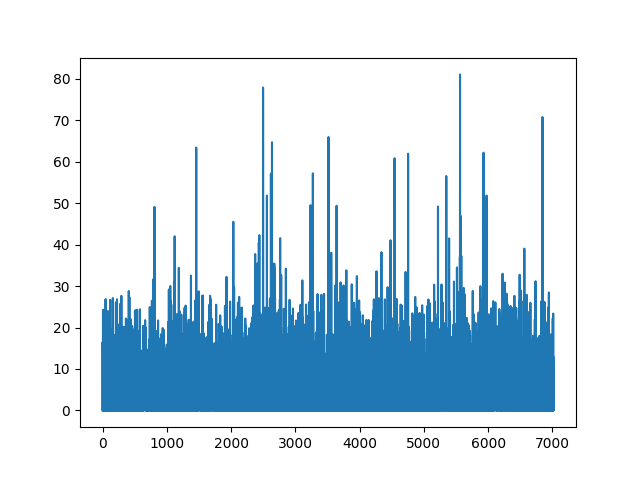

In [ ]:
plt.figure()
plt.plot(dat['sresp'][100,:])

NameError: ignored

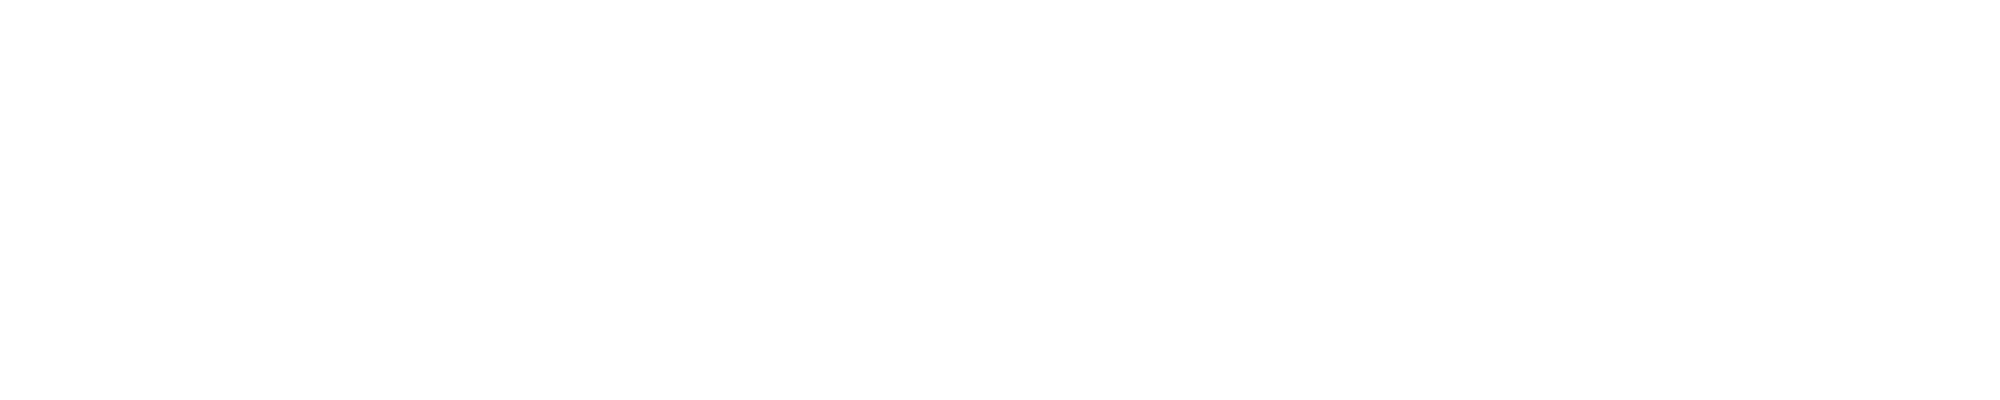

In [ ]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_) / np.sum(pca.explained_variance_) *100)

NameError: ignored

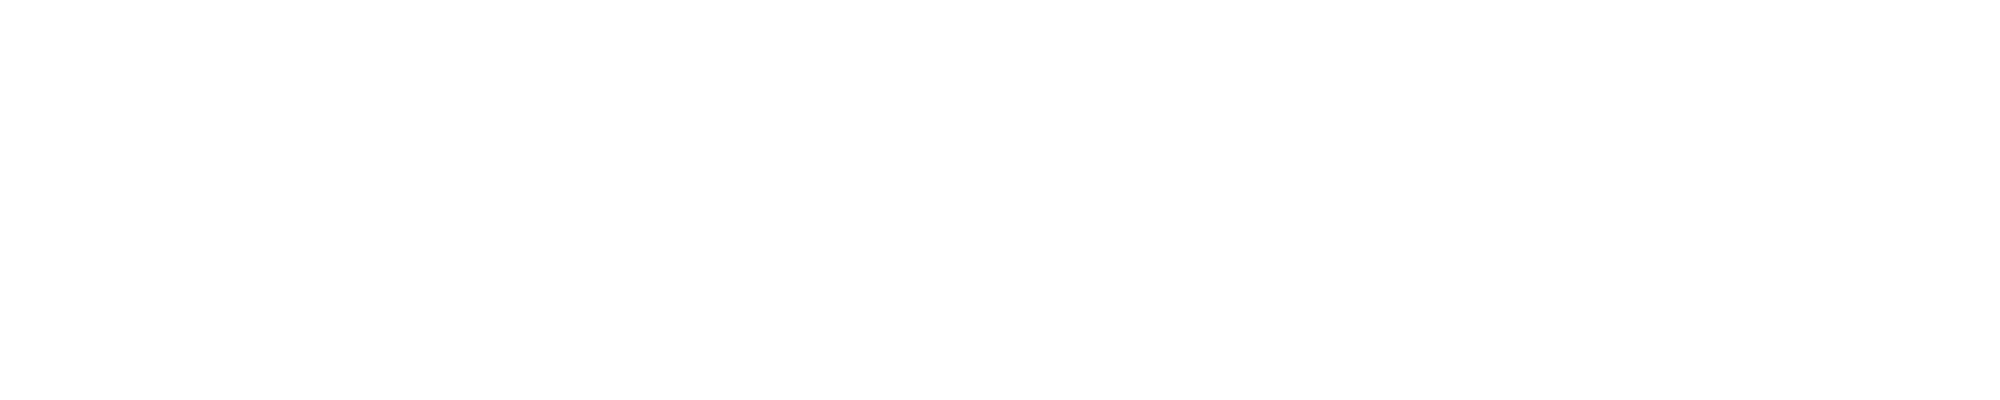

In [ ]:
plt.figure()
plt.scatter(embed[:,0], embed[:,1])

In [ ]:
print(embed.shape)

NameError: ignored

In [ ]:
embed = embed.flatten()
isort = np.argsort(embed)
RasterMap = uniform_filter1d(Z[isort, :], size=50, axis=0)
RasterMap = zscore(RasterMap[::10, :], axis=1)

NameError: ignored

NameError: ignored

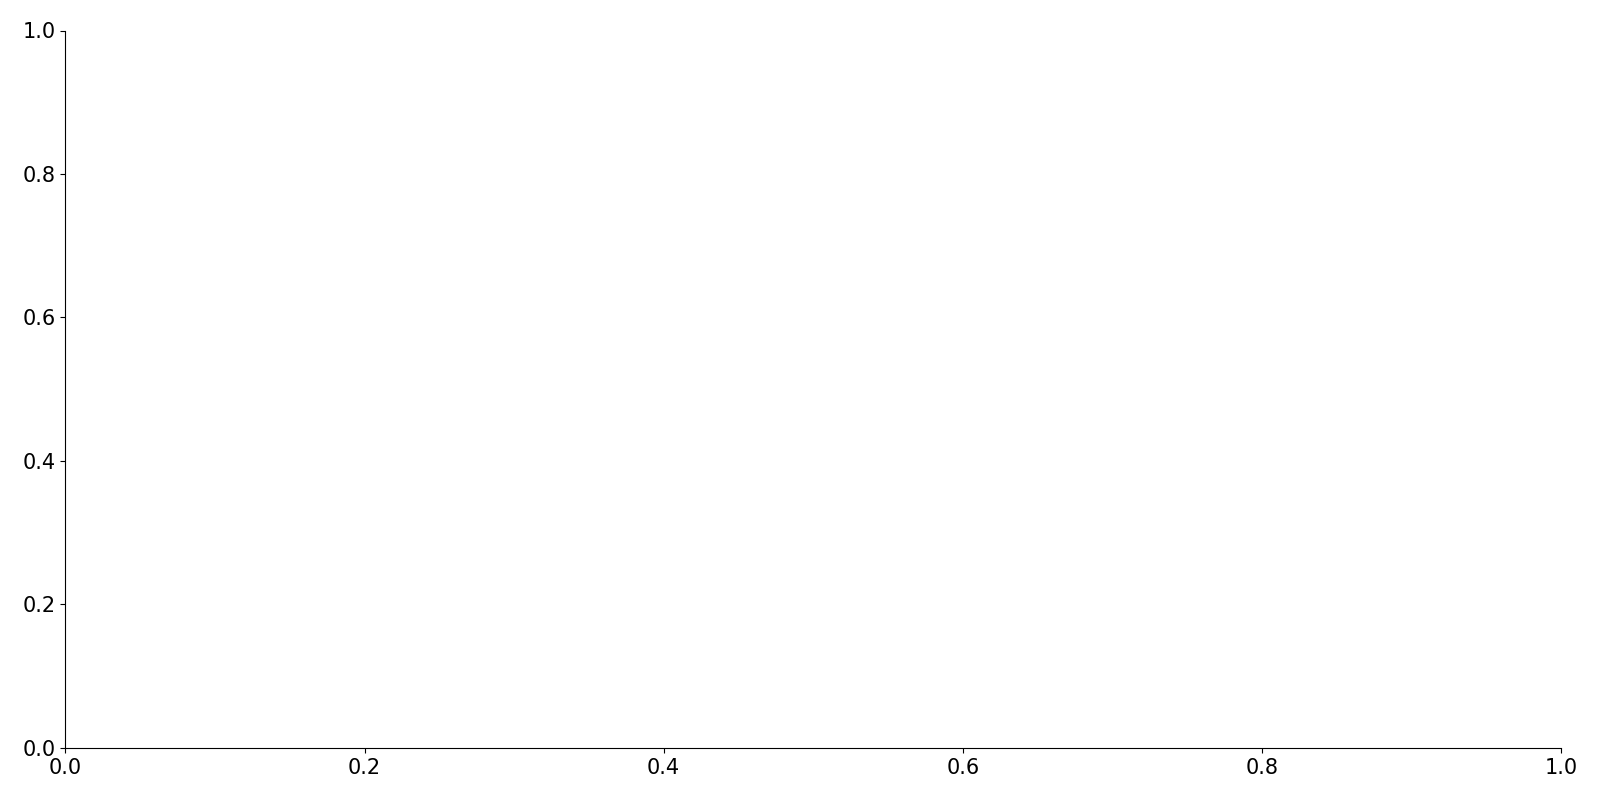

In [ ]:
plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
trange = np.arange(1100, 1400)
plt.imshow(RasterMap[:, trange], vmax= 3, vmin=-1, aspect='auto', cmap='gray_r')
ax.set(xlabel='timepoints', ylabel='sorted neurons')
plt.show()

In [ ]:
# now sort with UMAP both the neuron axis and the timepoints axis, bin the sorted matrix and make a sorted Rastermap picture

# Check cross-correlation between observed behaviors

In [ ]:
for key, data in dat.items():
  print(f"{key}: {data.dtype}, shape: {data.shape}")

In [ ]:
pupil = zscore(dat['pupilArea'], axis=0, nan_policy='omit')
eye_pos = dat['pupilCOM']
locomotion = zscore(dat['run'], axis=0, nan_policy='omit')
face_svd = zscore(dat['beh_svd_time'], axis=0, nan_policy='omit')

In [ ]:
# Obtain the euclidian distance between consecutive eye COM positions
diff = np.diff(eye_pos, axis=0)
sq_diff = diff**2
sq_distance = np.sum(sq_diff, axis=1)
distance = np.sqrt(sq_distance)
eye_speed = zscore(distance, axis=0, nan_policy='omit')
eye_speed = np.pad(eye_speed, (0,1), mode='mean')

In [ ]:
eye_speed = zscore(distance, axis=0, nan_policy='omit')
import numpy as np

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]
nans, x= nan_helper(eye_speed)
eye_speed[nans]= np.interp(x(nans), x(~nans), eye_speed[~nans])
print(eye_speed[-10:])

In [ ]:
np.any(np.isnan(eye_speed))

In [ ]:
plt.figure()
plt.plot(pupil, c='blue')
plt.plot(locomotion, c='green')
plt.plot(eye_speed, c='black')
plt.title('Visual inspection of similarity of behavior traces')

In [ ]:
all_behaviors = np.stack([eye_speed, np.squeeze(locomotion), np.squeeze(pupil), face_svd[...,0]], axis=0)
print(all_behaviors.shape)

In [ ]:
from scipy.spatial.distance import pdist, squareform
distances = pdist(all_behaviors, 'correlation')
square_distances = squareform(distances)
cross_correlations = 1 - square_distances #pdist 'correlation' actually calculates 1 - correlation, subtract from one to obtain correlation coefficient


In [ ]:
plt.figure()
plt.imshow(cross_correlations)
plt.colorbar()
plt.title('Cross-correlation between manually selected behaviors')

`

# Hierarchical Clustering of all neurons

In [ ]:
dat['sresp'].shape

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

data = dat['sresp']
# Compute pairwise distances using correlation as the distance metric
distances = pdist(data, 'correlation')

# Perform hierarchical clustering using precomputed distances
clusters = linkage(distances, method='complete')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(clusters)
plt.show()


# GLM to predict pupil diameter from neural activity

How much detail in behavior can V1 predict? -> PC of behaviors. PC1 contains a lot of the shared variance. How many dimensions could we reliably predict?

**Data preparation**: z-scoring (standardization) of the weight matrix, potentially exluding everything over 5. set from 0 to 1. What else would we do with the data to prepare it?

Some behaviors will not be detectable with 1.2 seconds time resolution.

In [ ]:
pupil = zscore(dat['pupilArea'], axis=0, nan_policy='omit')
eye_pos = dat['pupilCOM']
locomotion = zscore(dat['run'], axis=0, nan_policy='omit')
face_svd = zscore(dat['beh_svd_time'], axis=0, nan_policy='omit')

In [ ]:
def normalize_data(data: np.array, new_min: int, new_max: int, axis=None):
    if axis is None:
        # Perform normalization across the entire array
        return ((data - np.min(data)) * (new_max - new_min) / (np.max(data) - np.min(data))) + new_min
    else:
        # Perform normalization along the specified axis
        min_vals = np.min(data, axis=axis, keepdims=True)
        max_vals = np.max(data, axis=axis, keepdims=True)
        return ((data - min_vals) * (new_max - new_min) / (max_vals - min_vals)) + new_min



# Build the full design matrix
# Predict pupil diameter: y = pupil
y = pupil
y = normalize_data(y, new_min=0, new_max=1)

# solve: yhat = x theta, theta =X.T y / X.T X
x = neuron_response = dat['sresp']

# Normalize, center to the mean and scale from 0 to 1
x = zscore(x, axis=1)
x = normalize_data(x, new_min=0, new_max=1, axis=1)

constant = np.ones((1, x.shape[1])) # accounts for offset
X = np.concatenate([constant, x], axis=0).T


In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
# Get the MLE weights for the LG model
theta = np.linalg.inv(X.T @ X) @ X.T @ y

# Compute predicted spike counts
yhat_np = X @ theta

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(yhat_np[:500], c='red', label='predicted data')
plt.plot(y[:500], c='green', label='true data')
plt.legend()
plt.title('Visual estimation of goodness-of-prediction of the linear model')

In [ ]:
%matplotlib widget
plt.figure()
plt.plot(yhat_np[:100]/300, c='red', label='predicted data')
plt.plot(pupil[:100], c='green', label='true data')
plt.legend()
plt.title('Visual estimation of goodness-of-prediction of the linear model')

In [ ]:
print(X.shape)

## GLM using the sklearn toolbox

In [ ]:
from sklearn.linear_model import LinearRegression

# assuming y is a 2D array with shape (n_samples, 1)
# and x is a 2D array with shape (n_samples, n_features)
y = np.squeeze(pupil)
y = zscore(y)
y = normalize_data(y, new_min=0, new_max=1)


x = dat['sresp'].T
x = zscore(x, axis=1)
x = normalize_data(x, new_min=0, new_max=1, axis=1)

# Initialize the model
model = LinearRegression() # https://scikit-learn.org/stable/modules/linear_model.html

# Fit the model
model.fit(x, y)

# Now, you can predict new data using:
yhat = model.predict(x)


In [ ]:
x.shape

(7018, 11983)

In [ ]:
y.shape

(7018,)

In [ ]:
model.coef_.shape

(11983,)

In [ ]:

neural = dat['sresp']
np.array([[i] for i in range(neural.shape[0])])[:7018, 0].shape

(7018,)

In [ ]:
np.array([[i] for i in range(neural.shape[0])]).shape

(11983, 1)

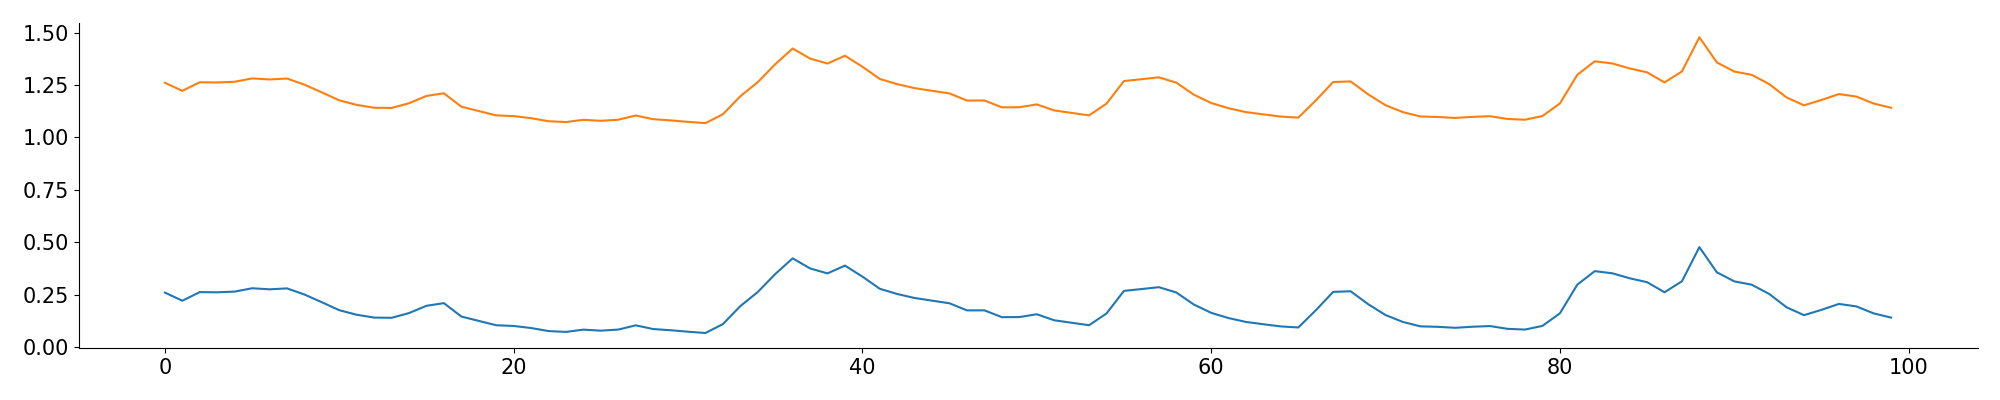

In [ ]:
plt.figure()
plt.plot(yhat[:100])
plt.plot(y[:100] +1)

In [ ]:
# Re-try the OLS Regression, but use the train-test split from Stringer2019
timepoints, no_neurons = x.shape
X_1_train = x[:timepoints//2, :no_neurons//2]
X_1_test = x[timepoints//2:, :no_neurons//2]
X_2_train = x[:timepoints//2, no_neurons//2:]
X_2_test = x[timepoints//2:, no_neurons//2:]
y_train = y[:timepoints//2]
y_test = y[timepoints//2:]

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

regr = LinearRegression()
# Train the model using the training sets
regr.fit(X_1_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_1_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))


Coefficients: 
 [ 0.00156144 -0.04015527 -0.03018462 ... -0.01908584  0.07472023
 -0.00536137]
Mean squared error: 0.02
Coefficient of determination: 0.32


In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(regr, x, y, cv=8)  # k=8 cross validation


How do we evaluate our model performance? Sum of pointwise mean squared error. Circular shift permutation. Re-do modelling. Look at distribution of the MSE from all circular shift permutations. Where does our MSE lie within this distribution? While doing that we will also obtain new Θ matrices, from the distribution of the wieghts from all Θ matrices we can also estimate how well our weights are within this. -> which neurons contribute significantly to this model?

In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (accuracies.mean(), accuracies.std()))

0.45 accuracy with a standard deviation of 0.20


Text(0.5, 1.0, 'Model predicition of held-out test data')

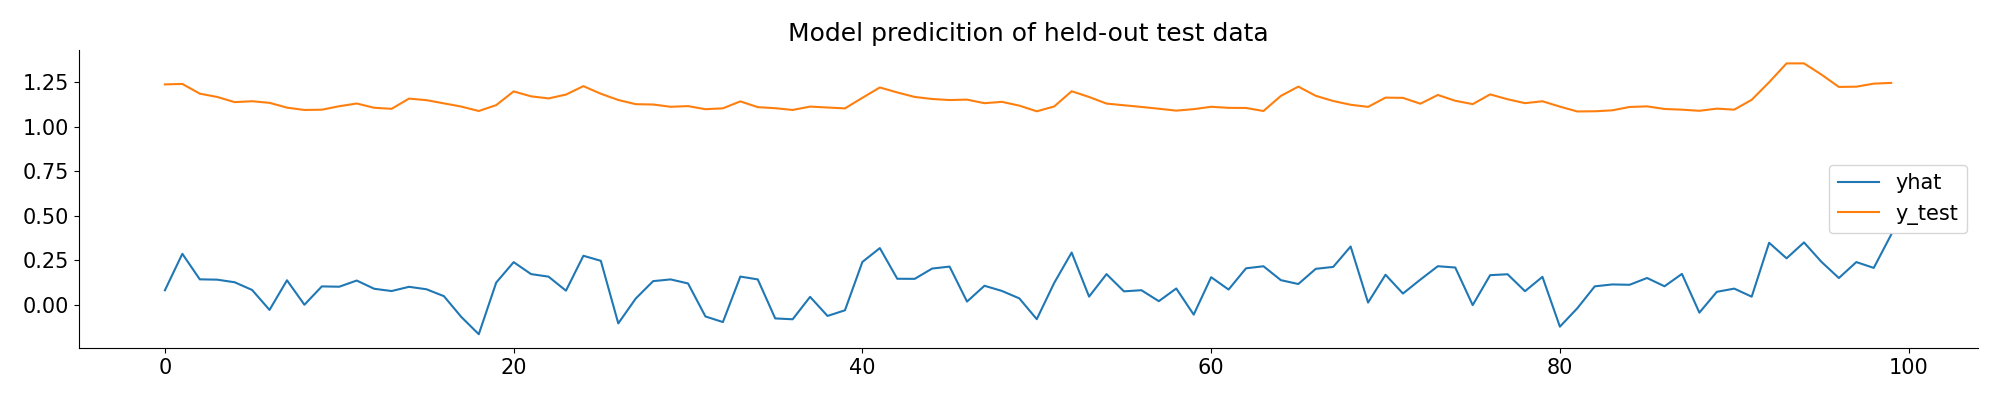

In [ ]:
plt.figure()
plt.plot(y_pred[:100], label='yhat')
plt.plot(y_test[:100] +1, label='y_test')
plt.legend()
plt.title('Model predicition of held-out test data')

In [ ]:
print(y_pred.shape)
print(y.shape)

### L1 Regularization

Text(0.5, 1.0, 'Model predicition of held-out test data')

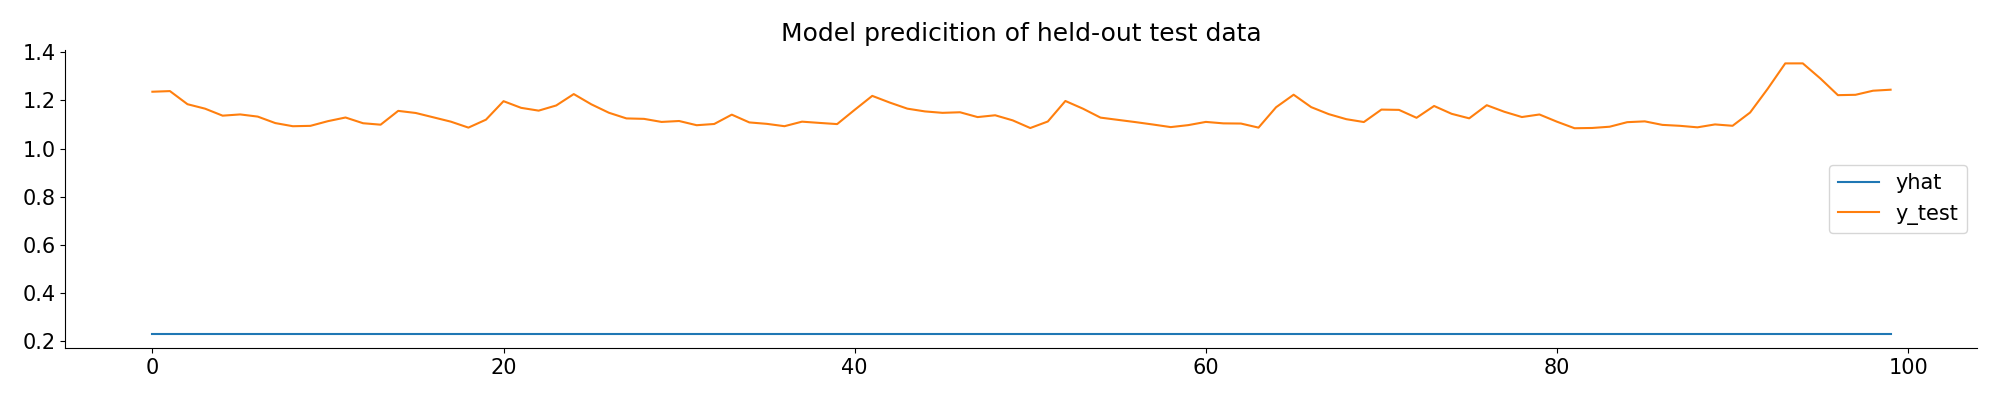

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, shuffle=False)

reg_l1 = Lasso(alpha=0.1)

# Train the model using the training sets
reg_l1.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_l1 = reg_l1.predict(X_test)


plt.figure()
plt.plot(y_pred_l1[:100], label='yhat')
plt.plot(y_test[:100] +1, label='y_test')
plt.legend()
plt.title('Model predicition of held-out test data')

L1 with standard parameters does not seem to predict well at all. I'll use time series cross validation to tune this hyperparameter, as suggested here: https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_and_elasticnet.html#sphx-glr-auto-examples-linear-model-plot-lasso-and-elasticnet-py


It is important to keep in mind that the coefficients that have been dropped may still be related to the outcome by themselves: the model chose to suppress them because they bring little or no additional information on top of the other features. Additionally, this selection is unstable for correlated features, and should be interpreted with caution.

In [ ]:
from time import time
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

# This is Chat GPT's suggestion on how to implement a good cross-validation scheme for time series data
# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

t0 = time()
#lasso_cv takes a cross-validation scheme as a parameter
lasso_cv = LassoCV(cv=tscv).fit(X_train, y_train)
print(f"LassoCV fit done in {(time() - t0):.3f}s")

y_pred_lasso = lasso_cv.predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(f"LassoCV r^2 on test data : {r2_score_lasso:.3f}")
print(f"Optimal alpha : {lasso_cv.alpha_}")


LassoCV fit done in 199.528s
LassoCV r^2 on test data : 0.573
Optimal alpha : 2.69960735481984e-05


Yes, you can certainly pass your `TimeSeriesSplit` cross-validation generator to `cross_val_score`.

By default, if no specific cross-validation argument is passed, `cross_val_score` uses a 5-fold cross-validation. However, this default method does not take into account the temporal structure of time series data.

For time series data, we want to ensure that we're training on past data and validating on future data. That's why we use `TimeSeriesSplit`.

In a 5-fold cross-validation, the data would be divided into 5 equal parts and the validation would take place five times, each time using a different part for validation and the rest for training. This might look like:

```
Fold 1: |---- val ----|-------------------- train ----------------------|
Fold 2: |----- train -----|---- val ----|-------------- train ------------|
Fold 3: |---------- train ----------|---- val ----|------- train -------|
Fold 4: |--------------- train ---------------|---- val ----|--- train ---|
Fold 5: |--------------------- train ---------------------|---- val ----|
```
As you can see, this doesn't maintain the temporal order of the data because it uses future data in the training set.

If you want to maintain the order of the data (which you usually do in time-series analysis), you should use `TimeSeriesSplit`, which gives:

```
Split 1: |---- train ----| val |------------------- unused ------------------|
Split 2: |--------- train --------| val |------------------ unused ------------|
Split 3: |-------------- train ------------| val |-------------- unused -------|
Split 4: |------------------- train ------------------| val |----- unused ----|
Split 5: |------------------------ train ---------------------| val |--- unused |
```

As you can see, `TimeSeriesSplit` ensures that the validation set always comes after the training set, maintaining the temporal order.

Text(0.5, 1.0, 'Model predicition of held-out test data')

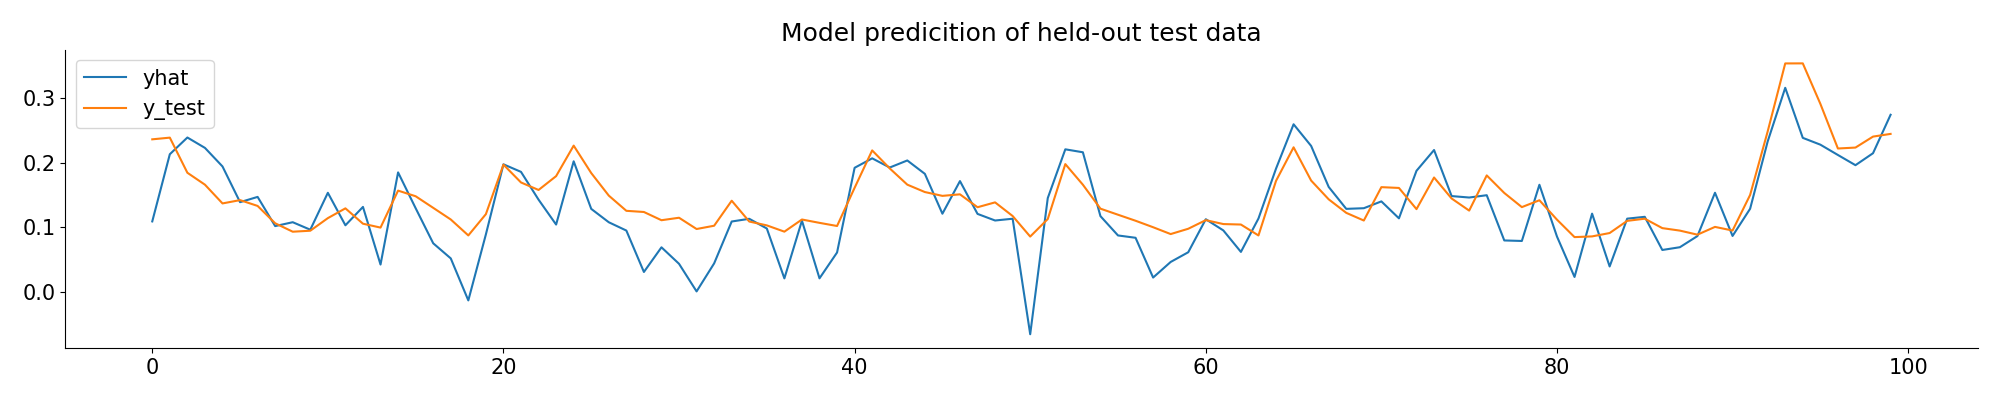

In [ ]:
reg_l1 = Lasso(alpha=lasso_cv.alpha_)

# Train the model using the training sets
reg_l1.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_l1 = reg_l1.predict(X_test)


plt.figure()
plt.plot(y_pred_l1[:100], label='yhat')
plt.plot(y_test[:100], label='y_test')
plt.legend()
plt.title('Model predicition of held-out test data')

In [ ]:
accuracies = cross_val_score(reg_l1, X_train, y_train, cv=tscv)
print("%0.2f accuracy with a standard deviation of %0.2f" % (accuracies.mean(), accuracies.std()))

0.24 accuracy with a standard deviation of 0.91


Log reg makes only discrete predictions, take a look at that later

In [ ]:
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.
  """
  #############################################################################
  # TODO Complete the function, then remove the next line to test it
  # raise NotImplementedError("Implement the compute_accuracy function")
  #############################################################################

  y_pred = model.predict(X)

  accuracy = np.sum(y == y_pred) / len(y)

  return accuracy


# Compute train accuracy
train_accuracy = compute_accuracy(X, y, log_reg)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

# Deep Learning


In [ ]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# @title Helper and plotting Functions

def plot_data_matrix(X, ax, show=False):
  """Visualize data matrix of neural responses using a heatmap

  Args:
    X (torch.Tensor or np.ndarray): matrix of neural responses to visualize
        with a heatmap
    ax (matplotlib axes): where to plot
    show (boolean): enable plt.show()

  """

  cax = ax.imshow(X, cmap=mpl.cm.pink, vmin=np.percentile(X, 1),
                  vmax=np.percentile(X, 99))
  cbar = plt.colorbar(cax, ax=ax, label='normalized neural response')

  ax.set_aspect('auto')
  ax.set_xticks([])
  ax.set_yticks([])
  if show:
    plt.show()


def plot_train_loss(train_loss):
  plt.plot(train_loss)
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.xlabel('iterations of gradient descent')
  plt.ylabel('mean squared error')
  plt.show()


def get_data(n, train_data, train_labels):
  """ Return n_stim randomly drawn stimuli/resp pairs

  Args:
    n_stim (scalar): number of samples to draw
    resp (torch.Tensor):
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians

  Returns:
    (torch.Tensor, torch.Tensor): n_stim x n_neurons tensor of neural responses and n_stim x 1 of orientations respectively
  """
  n_stimuli = train_labels.shape[0]
  istim = np.random.choice(n_stimuli, n)
  r = train_data[istim]  # neural responses to this stimulus
  pupil = train_labels[istim]  # true stimulus orientation

  return r, pupil

In [ ]:
# @title Get and prepare data
responses = dat['sresp'].T
pupil = dat['pupilArea'].T[0]
n_pupil = pupil.shape[0]
print(responses.shape, pupil.shape, n_pupil)

resp_all = torch.tensor(responses, dtype=torch.float32)
pupil_all = torch.tensor(pupil, dtype=torch.float32).unsqueeze(1)
n_pupil, n_neurons = resp_all.shape
print(resp_all.shape, pupil_all.shape)

(7018, 11983) (7018,) 7018
torch.Size([7018, 11983]) torch.Size([7018, 1])


In [ ]:
# @title Split into training and test sets

# Set random seeds for reproducibility
np.random.seed(4)
torch.manual_seed(4)

# Split data into training set and testing set
nresp_train = int(0.6 * n_neurons)  # use 60% of all data for training set
npup_train = int(0.6 * n_pupil)
#train data
resp_train = resp_all[:npup_train , :nresp_train]
pupil_train = pupil_all[:npup_train]
#test data
resp_test = resp_all[npup_train: , nresp_train:]
pupil_test = pupil_all[npup_train:]
#reshape pupil data
pupil_newtrainshape = (pupil_train.shape[0])
pupil_train = pupil_train.view(pupil_newtrainshape)
pupil_newtestshape = (pupil_test.shape[0])
pupil_test = pupil_test.view(pupil_newtestshape)

In [ ]:
print(resp_train.shape, pupil_train.shape)

torch.Size([4210, 7189]) torch.Size([4210])


In [ ]:
# @title Batch data

from torch.utils.data import DataLoader, TensorDataset

# Get neural responses (resp) to and pupil size (pupil) to one stimulus in dataset
# resp, pupil = get_data(1, resp_train, pupil_train)  # using helper function get_data
# print(resp.shape, pupil.shape)
dataset = torch.utils.data.TensorDataset(resp_train, pupil_train)
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# @title Initialize neural network and optimizer function

class DeepNetReLu(nn.Module):
  """Deep Network with one hidden layer

  Args:
    n_inputs (int): number of input units
    n_hidden (int): number of units in hidden layer

  Attributes:
    in_layer (nn.Linear): weights and biases of input layer
    out_layer (nn.Linear): weights and biases of output layer

  """

  def __init__(self, n_inputs, n_hidden):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, 1) # hidden units --> output

  def forward(self, r):
    """Decode pupil size from neural responses

    Args:
      r (torch.Tensor): vector of neural responses to decode, must be of
        length n_inputs. Can also be a tensor of shape n_stimuli x n_inputs,
        containing n_stimuli vectors of neural responses

    Returns:
      torch.Tensor: network outputs for each input provided in r. If
        r is a vector, then y is a 1D tensor of length 1. If r is a 2D
        tensor then y is a 2D tensor of shape n_stimuli x 1.

    """
    h = torch.relu(self.in_layer(r))
    y = self.out_layer(h) # y is size (n_inputs, 1)
    return y


class PupilRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(PupilRNN, self).__init__()

        self.hidden_size = hidden_size # number of hidden units
        self.num_layers = num_layers # number of hidden layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        x = x.unsqueeze(1)  # Erweitert die Batch-Dimension
        x = x.repeat(1, h0.size(1), 1)  # Wiederholt x entlang der Batch-Dimension
        #import pdb; pdb.set_trace()
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


def train(net, loss_fn, input_data,
          n_epochs=10, learning_rate=1e-4):
  """Run gradient descent to optimize parameters of a given network

  Args:
    net (nn.Module): PyTorch network whose parameters to optimize
    loss_fn: built-in PyTorch loss function to minimize
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data
    n_epochs (int, optional): number of epochs of gradient descent to run
    learning_rate (float, optional): learning rate to use for gradient descent

  Returns:
    (list): training loss over iterations

  """

  # Initialize PyTorch SGD optimizer
  optimizer = optim.SGD(net.parameters(), lr=learning_rate)

  # Placeholder to save outputs at each iteration
  train_loss = []
  outputs = []

  # Loop over epochs
  for i in range(n_epochs):

    for train_data, train_labels in dataloader:
      #import pdb; pdb.set_trace()
      # compute network output from inputs in train_data
      out = net(train_data)  # compute network output from inputs in train_data

      # evaluate loss function
      loss = loss_fn(out, train_labels)

      # Clear previous gradients
      optimizer.zero_grad()

      # Compute gradients
      loss.backward()

      # Update weights
      optimizer.step()

      # Store current value of outputs
      train_loss.append(loss.item())  # .item() needed to transform the tensor output of loss_fn to a scalar
      outputs.append(out)

      # Track progress
      if (i + 1) % (n_epochs // 1) == 0:
        print(f'iteration {i + 1}/{n_epochs} | loss: {loss.item():.3f}')
        # path='content/drive/'
        name=f'weights_{i}.pt'
        #fullpath= os.path.join(path, name)
        torch.save(net.state_dict(), name)

  return train_loss, outputs


In [ ]:
'''
# @title Run network

# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

hidden_size = 2000
num_layers = 100
input_size = n_neurons
output_size = pupil_batched.shape[2]
input_data = resp_batched


# Initialize network
rnn = PupilRNN(input_size, hidden_size, num_layers, output_size)

output = rnn(input_data)
print(output)
print(pupil_batched)
'''

'\n# @title Run network\n\n# Set random seeds for reproducibility\nnp.random.seed(1)\ntorch.manual_seed(1)\n\nhidden_size = 2000\nnum_layers = 100\ninput_size = n_neurons\noutput_size = pupil_batched.shape[2]\ninput_data = resp_batched\n\n\n# Initialize network\nrnn = PupilRNN(input_size, hidden_size, num_layers, output_size)\n\noutput = rnn(input_data)\nprint(output)\nprint(pupil_batched)\n'

In [ ]:
# @title Initialize network

# Initialize built-in PyTorch MSE loss function
loss_fn = nn.MSELoss()

# Network parameters
hidden_size = 100
num_layers = 3
input_size = resp_train.shape[1]
output_size = 1
input_data = dataloader

# Initialize network
rnn = PupilRNN(input_size, hidden_size, num_layers, output_size)

In [ ]:
# @title Train network and save weights

# train_loss = train(rnn, loss_fn, input_data, pupil)
# train_loss = train(rnn, loss_fn, input_data)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


iteration 10/10 | loss: 13450.253
iteration 10/10 | loss: 87908.289
iteration 10/10 | loss: 52648.133
iteration 10/10 | loss: 32490.270
iteration 10/10 | loss: 59115.980
iteration 10/10 | loss: 60380.965
iteration 10/10 | loss: 14328.908
iteration 10/10 | loss: 122741.180
iteration 10/10 | loss: 35732.832
iteration 10/10 | loss: 67552.141
iteration 10/10 | loss: 69518.625
iteration 10/10 | loss: 39930.547
iteration 10/10 | loss: 14604.854
iteration 10/10 | loss: 81383.438
iteration 10/10 | loss: 30486.107
iteration 10/10 | loss: 21029.281
iteration 10/10 | loss: 103080.469
iteration 10/10 | loss: 23051.180
iteration 10/10 | loss: 18980.746
iteration 10/10 | loss: 46382.828
iteration 10/10 | loss: 25716.514
iteration 10/10 | loss: 340170.469
iteration 10/10 | loss: 27701.539
iteration 10/10 | loss: 16107.350
iteration 10/10 | loss: 23568.482
iteration 10/10 | loss: 34271.648
iteration 10/10 | loss: 127529.703
iteration 10/10 | loss: 110540.188
iteration 10/10 | loss: 31396.031
iteration

RuntimeError: ignored

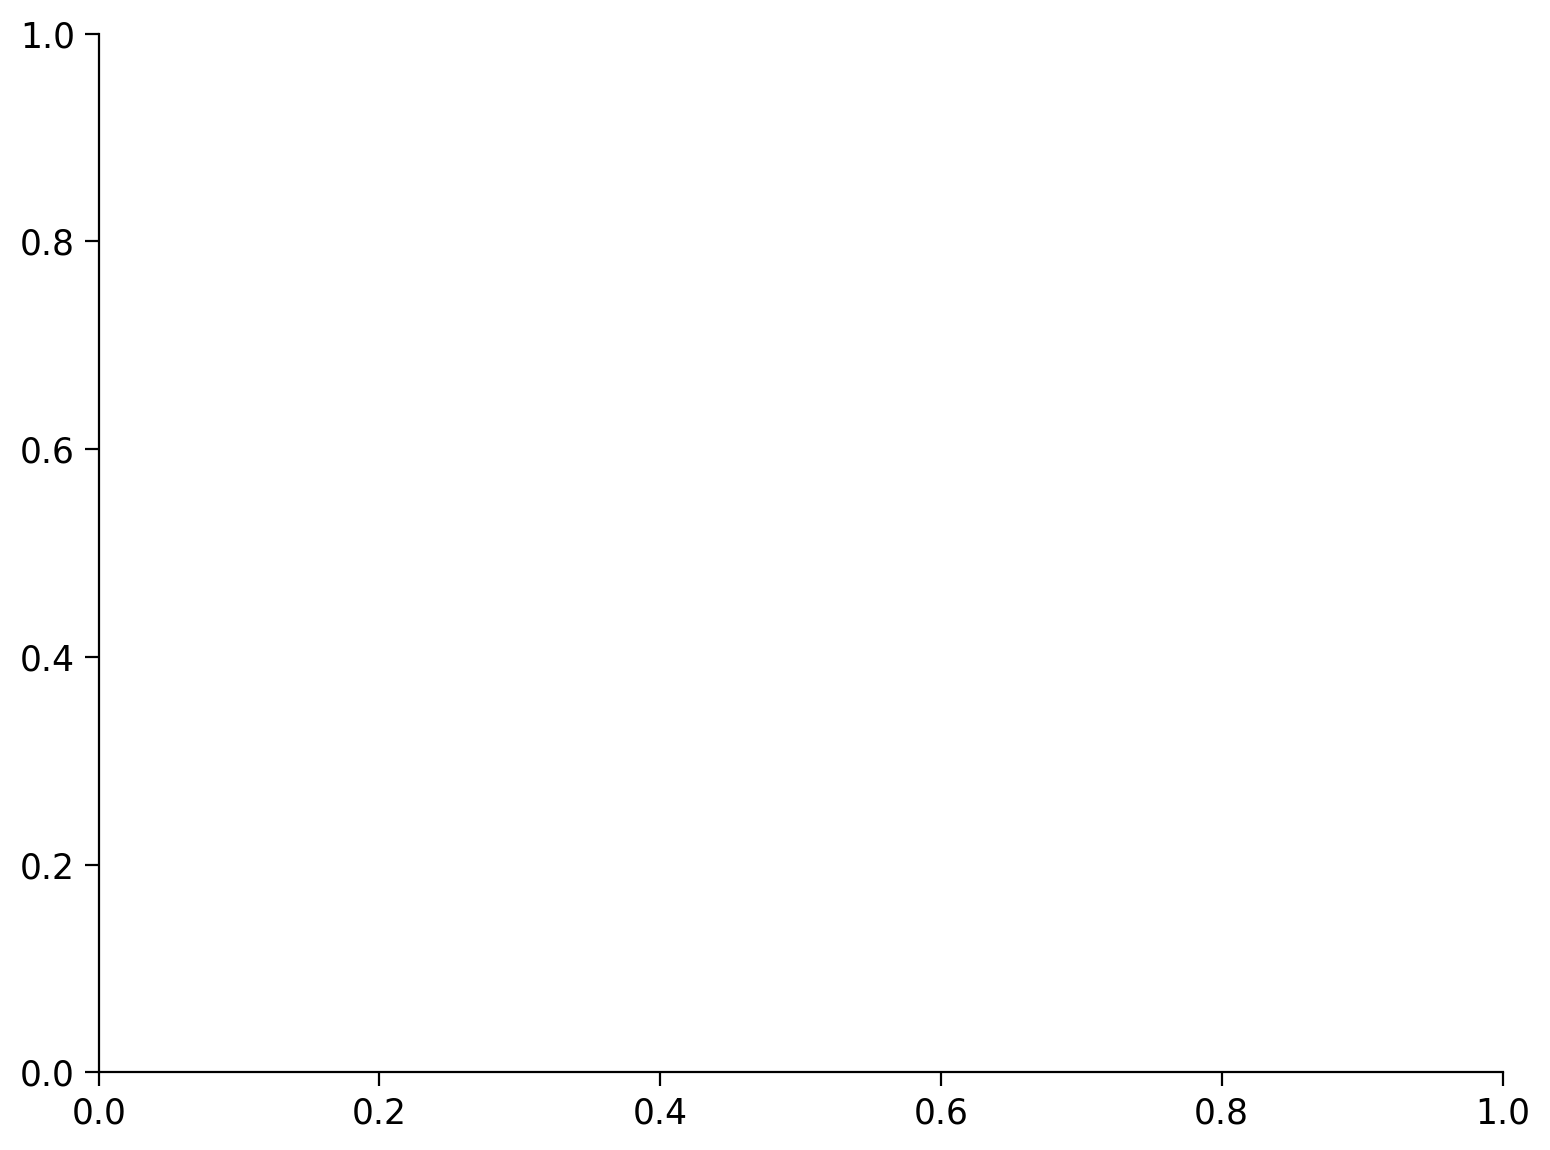

In [ ]:
# @title Plot the training loss over iterations
# plot_train_loss(train_loss)

In [ ]:
# @title Load trained model

path = '/content/weights_9.pt'
# Define which iteration to load
# i = 15
#name = f'weights_{i}.pt'
#fullname = os.path.join(path, name)

# Load model
# rnn = PupilRNN(input_size, hidden_size, num_layers, output_size)
statedict = rnn.load_state_dict(torch.load(path))
eval = rnn.eval()
weights = torch.load(path)

In [ ]:
weights.keys()

odict_keys(['rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'rnn.weight_ih_l1', 'rnn.weight_hh_l1', 'rnn.bias_ih_l1', 'rnn.bias_hh_l1', 'rnn.weight_ih_l2', 'rnn.weight_hh_l2', 'rnn.bias_ih_l2', 'rnn.bias_hh_l2', 'fc.weight', 'fc.bias'])

In [ ]:
weight_matrix = weights['rnn.weight_hh_l1']

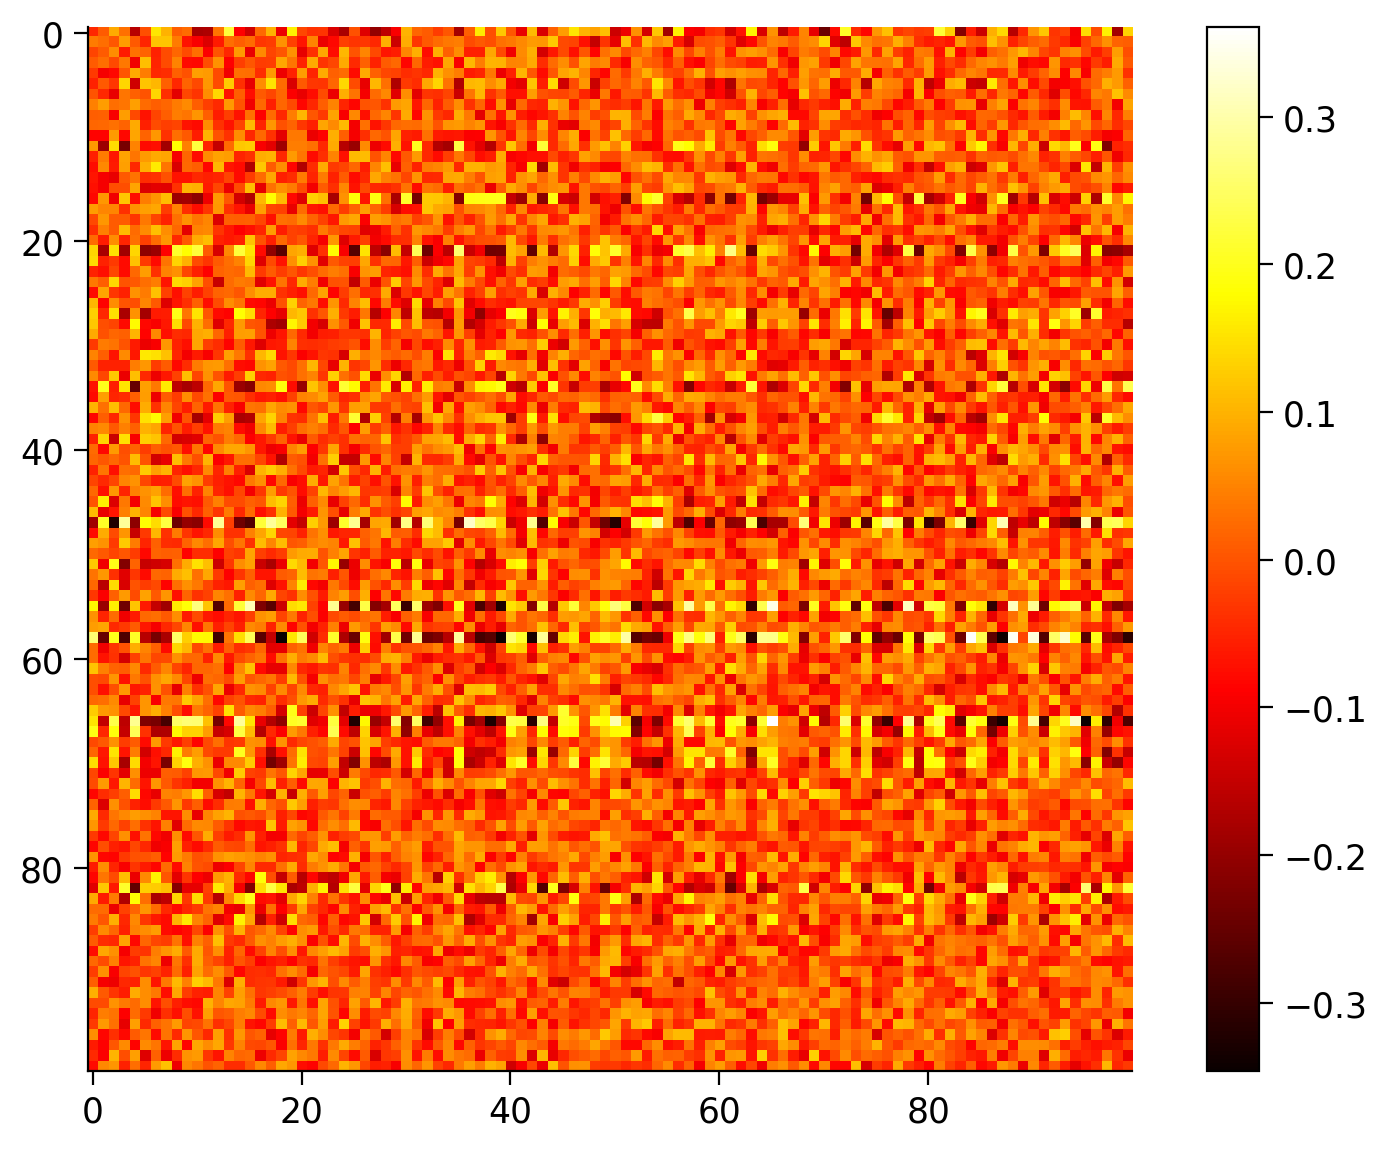

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Annahme: Gewichtsmatrix ist eine 2D-Numpy-Array
# weights = np.random.randn(10, 10)  # Beispielgewichtsmatrix

fig = plt.imshow(weight_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
# plt.show()
plt.savefig('weightshhl1_.png')

In [ ]:
# @title Apply model on test data
with torch.no_grad():
  predictions = rnn(resp_test)

In [ ]:
# @title Notes and comments

# Get neural responses (r) to and orientation (ori) to one stimulus in dataset
#r, ori = get_data(1, resp_train, pupil_train)  # using helper function get_data

# Decode orientation from these neural responses using initialized network
#out = net(r)  # compute output from network, equivalent to net.forward(r)

#print(f'decoded pupil size: {out.item():.2f} pixels')
#print(f'true pupil size: {ori.item():.2f} pixels')



# Initialize PyTorch mean squared error loss function (Hint: look at nn.MSELoss)
#loss_fn = nn.MSELoss()

# Evaluate mean squared error
#loss = loss_fn(out, pup)

#print(f'mean squared error: {loss:.2f}')


# Set random seeds for reproducibility
#np.random.seed(1)
#torch.manual_seed(1)

# Initialize a deep network with M=200 hidden units
#net = DeepNetReLu(n_neurons, 1000)

# Get neural responses (r) to and orientation (ori) to one stimulus in dataset
#r, pup = get_data(100, resp_train, pupil_train)  # using helper function get_data

# Decode orientation from these neural responses using initialized network
#out = net(r)  # compute output from network, equivalent to net.forward(r)
